In [605]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from sklearn.cluster import SpectralClustering

# Data Preparation

In [606]:
df_daily = pd.read_csv('eMAR daily consumption.csv')
display(df_daily.head())
df_house = pd.read_excel("eMARC household survey summary.xlsx")
display(df_house.head())

,Region,Household type,household_id,Deployment type,deployment_id,Date,Daily consumption (kWh)
0,Pune city,With Air Conditioners,H002,appliance,D0003,12/22/2019,1.039917
1,Pune city,With Air Conditioners,H002,appliance,D0003,12/23/2019,0.930054
2,Pune city,With Air Conditioners,H002,appliance,D0003,12/24/2019,1.059936
3,Pune city,With Air Conditioners,H002,appliance,D0003,12/25/2019,1.270020
4,Pune city,With Air Conditioners,H002,appliance,D0003,12/26/2019,1.010010


,HHID,Region,Rooms,No. of People,Area in Sqft,Inverter,Lights,Ceiling Fans,Air Coolers,Air-Conditioners,Fridge,TV,Water heaters,Washing Machine,Mixer,Iron,Micro-wave
0,H001,Pune city,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1
1,H002,Pune city,5.0,4,1100.0,0.0,14,5,0,3.0,1,1,1,1,1,1,1
2,H003,Pune city,5.0,2,1000.0,0.0,16,6,0,0.0,1,1,3,1,1,1,1
3,H004,Pune city,3.0,7,550.0,0.0,10,2,0,0.0,1,1,1,1,1,1,1
4,H005,Pune city,4.0,5,NaN,0.0,4,3,0,1.0,1,0,0,0,0,1,1


In [607]:
print("Exploring df_daily:")
display(df_daily.info())
print("\nExploring df_house:")
display(df_house.info())

Exploring df_daily:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111280 entries, 0 to 111279
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Region                   111280 non-null  object 
 1   Household type           111280 non-null  object 
 2   household_id             111280 non-null  object 
 3   Deployment type          111280 non-null  object 
 4   deployment_id            111280 non-null  object 
 5   Date                     111280 non-null  object 
 6   Daily consumption (kWh)  111280 non-null  float64
dtypes: float64(1), object(6)
memory usage: 5.9+ MB


None


Exploring df_house:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HHID              138 non-null    object 
 1   Region            138 non-null    object 
 2   Rooms             138 non-null    float64
 3   No. of People     138 non-null    int64  
 4   Area in Sqft      115 non-null    float64
 5   Inverter          132 non-null    float64
 6   Lights            138 non-null    int64  
 7   Ceiling Fans      138 non-null    int64  
 8   Air Coolers       138 non-null    int64  
 9   Air-Conditioners  137 non-null    float64
 10  Fridge            138 non-null    int64  
 11  TV                138 non-null    int64  
 12  Water heaters     138 non-null    int64  
 13  Washing Machine   138 non-null    int64  
 14  Mixer             138 non-null    int64  
 15  Iron              138 non-null    int64  
 16  Micro-wave        138 n

None

In [608]:
df_house['Area in Sqft'] = df_house.groupby(['Region'])['Area in Sqft'].transform(lambda x: x.fillna(x.median()))
display(df_house.info())
house = df_house[df_house['Air-Conditioners'].isna()]['HHID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HHID              138 non-null    object 
 1   Region            138 non-null    object 
 2   Rooms             138 non-null    float64
 3   No. of People     138 non-null    int64  
 4   Area in Sqft      138 non-null    float64
 5   Inverter          132 non-null    float64
 6   Lights            138 non-null    int64  
 7   Ceiling Fans      138 non-null    int64  
 8   Air Coolers       138 non-null    int64  
 9   Air-Conditioners  137 non-null    float64
 10  Fridge            138 non-null    int64  
 11  TV                138 non-null    int64  
 12  Water heaters     138 non-null    int64  
 13  Washing Machine   138 non-null    int64  
 14  Mixer             138 non-null    int64  
 15  Iron              138 non-null    int64  
 16  Micro-wave        138 non-null    int64  
dt

None

In [609]:
house_ids = df_house['HHID'].unique().tolist()
daily_ids = df_daily['household_id'].unique().tolist()

In [610]:
house_ids = set(df_house['HHID'])
daily_ids = set(df_daily['household_id'])

common_ids = list(house_ids.intersection(daily_ids))

print(f"Found {len(common_ids)} common IDs")

df_house_filtered = df_house[df_house['HHID'].isin(common_ids)]
df_daily_filtered = df_daily[df_daily['household_id'].isin(common_ids)]
print("daily_filtered head :")
print(df_daily_filtered.head())


Found 122 common IDs
daily_filtered head :
      Region         Household type household_id Deployment type  \
0  Pune city  With Air Conditioners         H002       appliance   
1  Pune city  With Air Conditioners         H002       appliance   
2  Pune city  With Air Conditioners         H002       appliance   
3  Pune city  With Air Conditioners         H002       appliance   
4  Pune city  With Air Conditioners         H002       appliance   

  deployment_id        Date  Daily consumption (kWh)  
0         D0003  12/22/2019                 1.039917  
1         D0003  12/23/2019                 0.930054  
2         D0003  12/24/2019                 1.059936  
3         D0003  12/25/2019                 1.270020  
4         D0003  12/26/2019                 1.010010  


# Computing behavioral features

In [611]:
import numpy as np
import pandas as pd


df_daily_filtered = df_daily_filtered.copy()

# Convert 'Date' to datetime
df_daily_filtered['Date'] = pd.to_datetime(df_daily_filtered['Date'], errors='coerce')
df_daily_filtered = df_daily_filtered.dropna(subset=['Date'])

# Calculate Yearly Average Consumption
yearly_avg_consumption = df_daily_filtered.groupby('household_id')['Daily consumption (kWh)'].mean().reset_index()
yearly_avg_consumption = yearly_avg_consumption.rename(columns={'Daily consumption (kWh)': 'Yearly Avg Consumption (kWh)'})
yearly_avg_consumption['Yearly Avg Consumption (kWh)'] = yearly_avg_consumption['Yearly Avg Consumption (kWh)']*365
behavioral_features_df = pd.merge(yearly_avg_consumption, df_house_filtered[['HHID', 'Area in Sqft', 'No. of People']], left_on='household_id', right_on='HHID', how='left')

# Calculate Per-Capita EUI
behavioral_features_df['Per-Capita EUI'] = behavioral_features_df['Yearly Avg Consumption (kWh)'] / behavioral_features_df['No. of People']
# behavioral_features_df['Per-Capita EUI'] = behavioral_features_df['Yearly Avg Consumption (kWh)'] / (behavioral_features_df['Area in Sqft'] * behavioral_features_df['No. of People'])


# Define seasons based on months
winter_months = [12, 1, 2]
summer_months = [3,4,5]

# Filter data for winter and summer
df_winter = df_daily_filtered[df_daily_filtered['Date'].dt.month.isin(winter_months)].copy()
df_summer = df_daily_filtered[df_daily_filtered['Date'].dt.month.isin(summer_months)].copy()

# Calculate average consumption for winter and summer per household
winter_avg_consumption = df_winter.groupby('household_id')['Daily consumption (kWh)'].mean().reset_index()
winter_avg_consumption = winter_avg_consumption.rename(columns={'Daily consumption (kWh)': 'Winter Avg Consumption (kWh)'})

summer_avg_consumption = df_summer.groupby('household_id')['Daily consumption (kWh)'].mean().reset_index()
summer_avg_consumption = summer_avg_consumption.rename(columns={'Daily consumption (kWh)': 'Summer Avg Consumption (kWh)'})
season_consumption = pd.merge(winter_avg_consumption, summer_avg_consumption, on='household_id', how='left')

# Calculate Season Ratio
season_consumption['Season Ratio'] = season_consumption.apply(lambda row: row['Winter Avg Consumption (kWh)'] / row['Summer Avg Consumption (kWh)'] if row['Summer Avg Consumption (kWh)'] != 0 else np.nan, axis=1)
behavioral_features_df = pd.merge(behavioral_features_df, season_consumption[['household_id', 'Season Ratio']], on='household_id', how='left')

# Calculate Consumption Volatility
consumption_volatility = df_daily_filtered.groupby('household_id')['Daily consumption (kWh)'].std().reset_index()
consumption_volatility = consumption_volatility.rename(columns={'Daily consumption (kWh)': 'Consumption Volatility'})
behavioral_features_df = pd.merge(behavioral_features_df, consumption_volatility, on='household_id', how='left')

display(behavioral_features_df.head())
display(behavioral_features_df.describe())

,household_id,Yearly Avg Consumption (kWh),HHID,Area in Sqft,No. of People,Per-Capita EUI,Season Ratio,Consumption Volatility
0,H001,790.175347,H001,625.0,3,263.391782,0.806784,1.063080
1,H002,2275.201391,H002,1100.0,4,568.800348,0.545110,6.680022
2,H003,1128.086327,H003,1000.0,2,564.043164,0.761767,1.331445
3,H004,2401.704119,H004,550.0,7,343.100588,1.197896,5.036270
4,H005,1324.810883,H005,750.0,5,264.962177,0.529218,2.623689


,Yearly Avg Consumption (kWh),Area in Sqft,No. of People,Per-Capita EUI,Season Ratio,Consumption Volatility
count,125.000000,125.000000,125.000000,125.000000,120.000000,124.000000
mean,1160.968377,806.416000,5.120000,258.061765,0.697491,2.225954
std,742.176464,361.528547,2.529184,169.039388,0.345357,1.848204
min,0.000000,200.000000,2.000000,0.000000,0.040434,0.145527
25%,727.983745,600.000000,4.000000,151.692262,0.514438,1.085078
50%,1010.319437,750.000000,5.000000,232.114392,0.662010,1.755080
75%,1333.615374,900.000000,6.000000,302.971060,0.819860,2.713506
max,4407.756344,2700.000000,18.000000,1098.129104,3.143398,10.343143


# K-means Clustering


In [612]:
from sklearn.preprocessing import StandardScaler

# features to scale
features_to_scale = ['Per-Capita EUI', 'Season Ratio', 'Consumption Volatility']
behavioral_features = behavioral_features_df[features_to_scale]

# Handle missing values before scaling
behavioral_features = behavioral_features.dropna()

#Scaling
scaler = StandardScaler()
scaled_behavioral_features = scaler.fit_transform(behavioral_features)
scaled_behavioral_features_df = pd.DataFrame(scaled_behavioral_features, columns=features_to_scale)

display(scaled_behavioral_features_df.head())

,Per-Capita EUI,Season Ratio,Consumption Volatility
0,-0.011431,0.317789,-0.653714
1,1.813444,-0.443077,2.380462
2,1.785019,0.186893,-0.508748
3,0.464844,1.455024,1.492536
4,-0.002048,-0.489288,0.189300


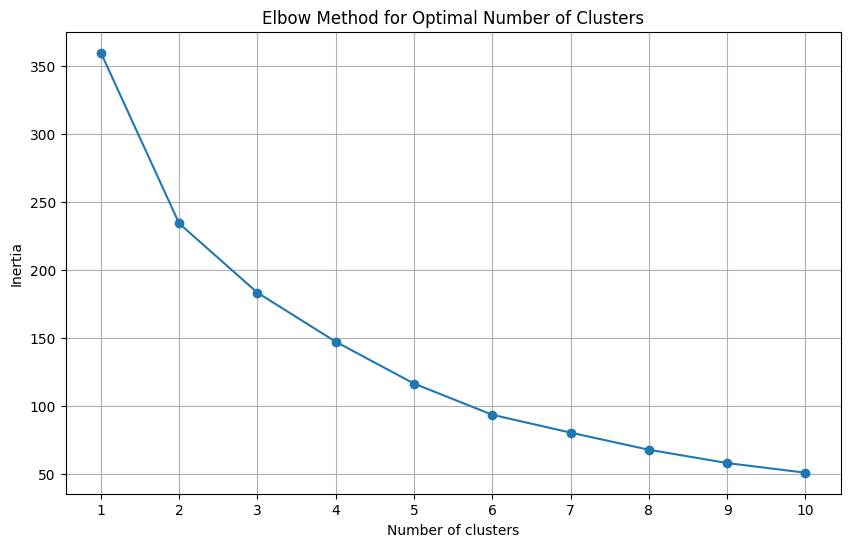

In [613]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method
inertia = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(scaled_behavioral_features)
    inertia.append(kmeans.inertia_)

# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

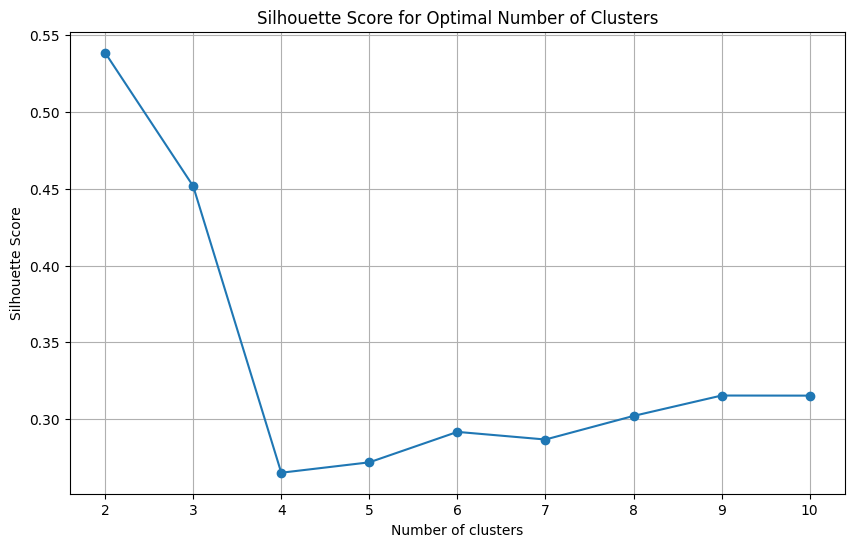

In [614]:
from sklearn.metrics import silhouette_score

# Silhouette Score
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(scaled_behavioral_features)
    score = silhouette_score(scaled_behavioral_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

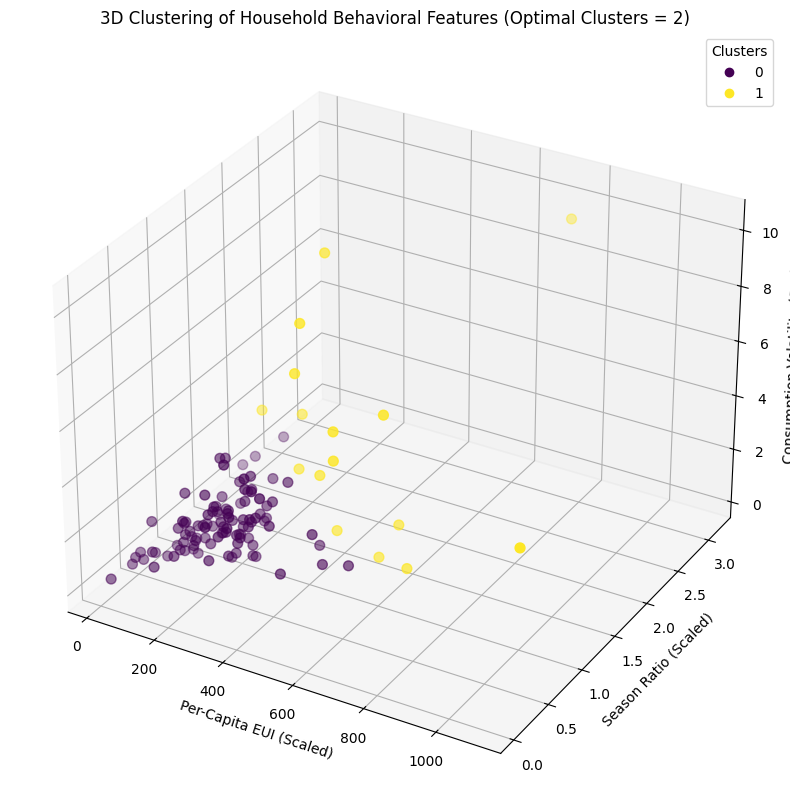

In [615]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

optimal_n_clusters = 2

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
kmeans.fit(scaled_behavioral_features)
cluster_labels_df = pd.DataFrame({'Cluster': kmeans.labels_}, index=behavioral_features.index)
behavioral_features['Cluster'] = cluster_labels_df['Cluster']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot points, colored by cluster
plot_df = behavioral_features.dropna(subset=['Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int) # Convert cluster labels to integer

scatter = ax.scatter(plot_df['Per-Capita EUI'],
                     plot_df['Season Ratio'],
                     plot_df['Consumption Volatility'],
                     c=plot_df['Cluster'],
                     cmap='viridis',
                     s=50)

ax.set_xlabel('Per-Capita EUI (Scaled)')
ax.set_ylabel('Season Ratio (Scaled)')
ax.set_zlabel('Consumption Volatility (Scaled)')
ax.set_title('3D Clustering of Household Behavioral Features (Optimal Clusters = {})'.format(optimal_n_clusters))

legend = ax.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

# Analysis

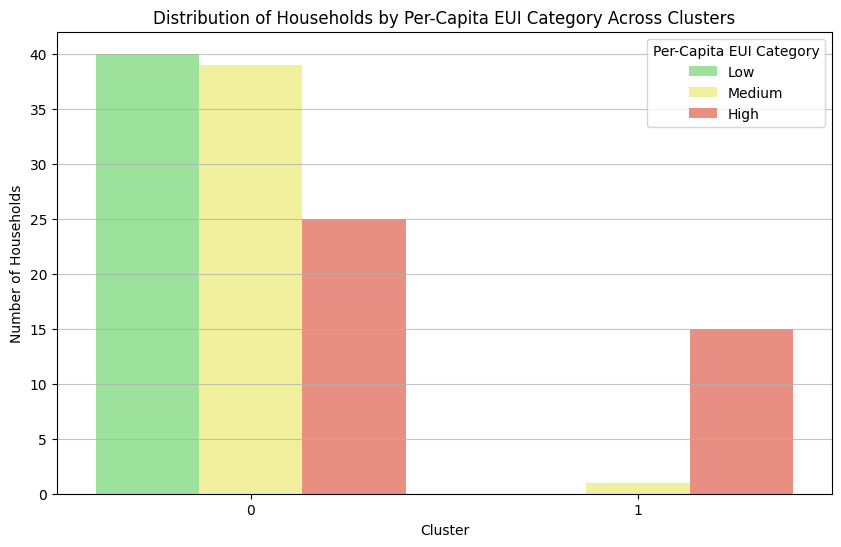

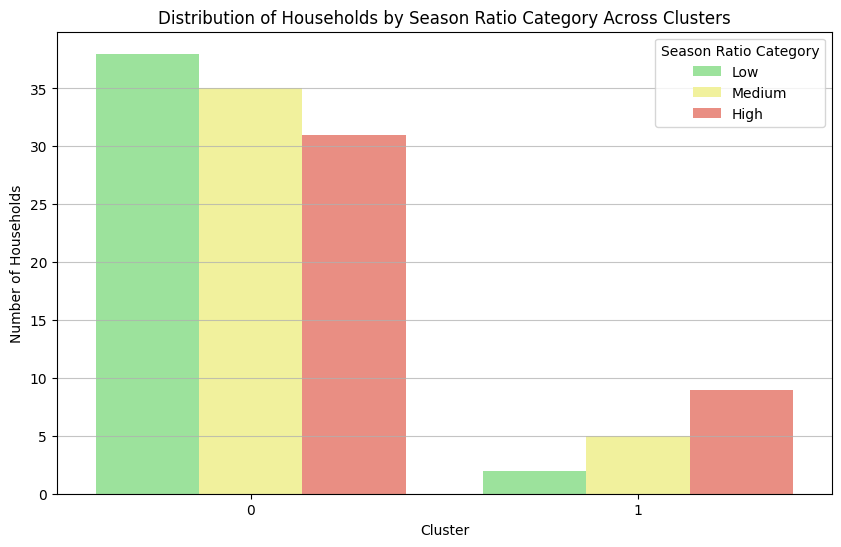

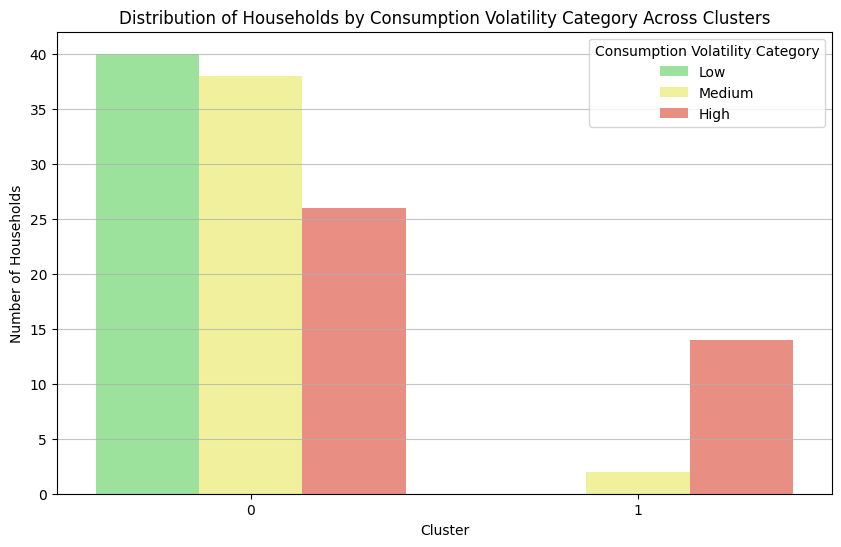

In [616]:
features_to_plot = ['Per-Capita EUI', 'Season Ratio', 'Consumption Volatility']

# Define thresholds
thresholds = {}
for feature in features_to_plot:
    low_threshold = behavioral_features[feature].quantile(0.33)
    high_threshold = behavioral_features[feature].quantile(0.67)
    thresholds[feature] = {'low': low_threshold, 'high': high_threshold}

# Categorize households
for feature in features_to_plot:
    behavioral_features[f'{feature}_Category'] = behavioral_features[feature].apply(
        lambda x: 'Low' if x <= thresholds[feature]['low'] else ('High' if x >= thresholds[feature]['high'] else 'Medium')
    )


custom_palette = {'Low': 'lightgreen', 'Medium': '#FFFF8F', 'High': 'salmon'} # Using hex code for yellow
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=behavioral_features, x='Cluster', hue=f'{feature}_Category', palette=custom_palette, hue_order = ["Low", "Medium", "High" ] )
    plt.xlabel('Cluster')
    plt.ylabel('Number of Households')
    plt.title(f'Distribution of Households by {feature} Category Across Clusters')
    plt.xticks(range(optimal_n_clusters))
    plt.legend(title=f'{feature} Category')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

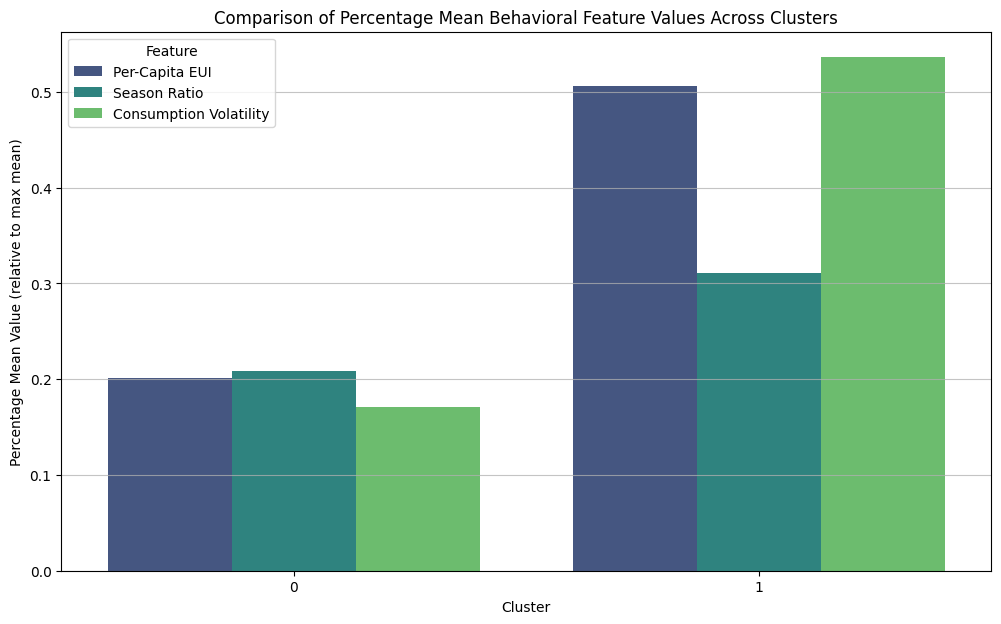

In [617]:

# Calculate the mean of each feature for each cluster
cluster_features_mean = behavioral_features.groupby('Cluster')[features_to_plot].mean().reset_index()
max_values = behavioral_features_df[features_to_plot].max()

epsilon = 1e-9

# Calculate the percentage mean for each feature in each cluster
percentage_mean_df = cluster_features_mean.copy()
for feature in features_to_plot:
    denominator = max_values[feature] if max_values[feature] != 0 else epsilon
    percentage_mean_df[feature] = percentage_mean_df[feature] / denominator


percentage_mean_melted = percentage_mean_df.melt(id_vars='Cluster', var_name='Feature', value_name='Percentage Mean')

plt.figure(figsize=(12, 7))
sns.barplot(data=percentage_mean_melted, x='Cluster', y='Percentage Mean', hue='Feature', palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Percentage Mean Value (relative to max mean)') # Updated label
plt.title('Comparison of Percentage Mean Behavioral Feature Values Across Clusters')
plt.xticks(range(optimal_n_clusters))
plt.grid(axis='y', alpha=0.75)
plt.legend(title='Feature')
plt.show()

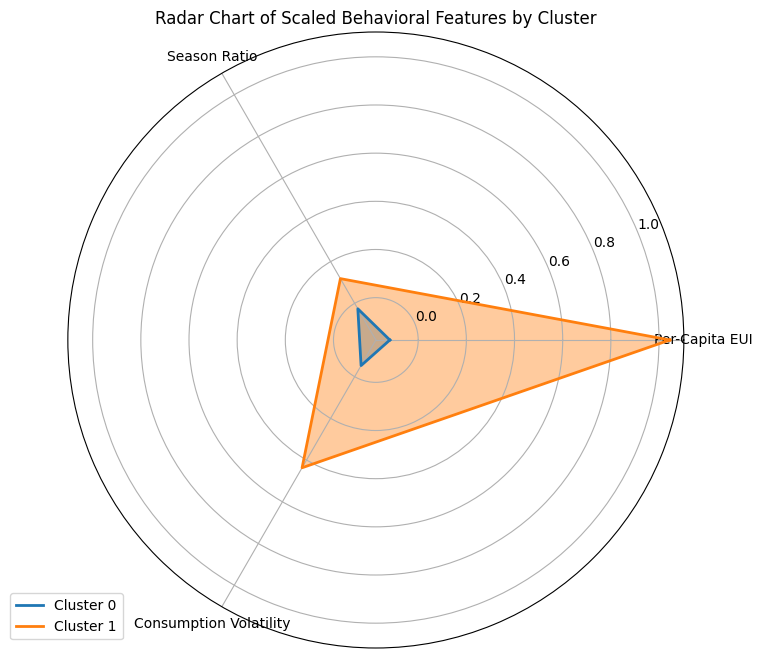

In [618]:
# Calculate the mean of the scaled features for each cluster
scaled_cluster_features_mean = scaled_behavioral_features_df.groupby(behavioral_features['Cluster']).mean().reset_index()
features = features_to_plot # ['Per-Capita EUI', 'Season Ratio', 'Consumption Volatility']
categories = list(scaled_cluster_features_mean.columns[1:])
N = len(categories)
values = [scaled_cluster_features_mean.loc[i, categories].tolist() for i in range(optimal_n_clusters)]


# close the circle
values = [v + [v[0]] for v in values]
categories = categories + [categories[0]]

# angles
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles = angles + [angles[0]]

# Create the chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i in range(optimal_n_clusters):
    ax.plot(angles, values[i], linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values[i], alpha=0.4)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories[:-1])
plt.title('Radar Chart of Scaled Behavioral Features by Cluster')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

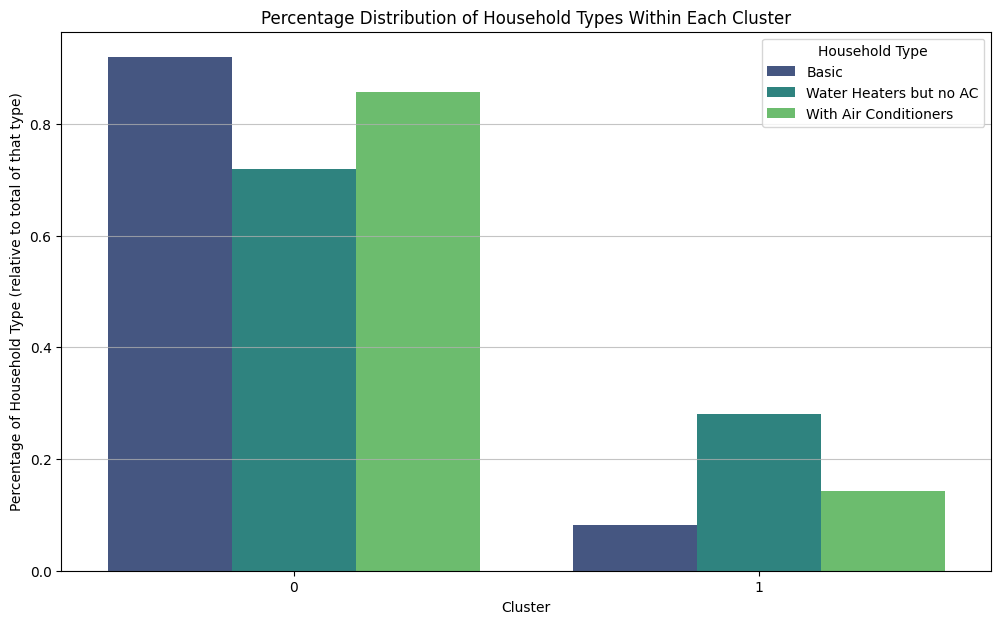

In [619]:
behavioral_features["household_id"] = behavioral_features_df["household_id"]

# Create a mapping from household_id to Household type
household_type_mapping = (
    df_daily_filtered[['household_id', 'Household type']]
    .drop_duplicates()
    .set_index('household_id')['Household type'])
behavioral_features['Household type'] = behavioral_features['household_id'].map(household_type_mapping)


# Calculate the total count for each household type across all clusters
total_household_type_counts = behavioral_features['Household type'].value_counts()


# Calculate the count of each household type within each cluster
cluster_household_type_counts = behavioral_features.groupby('Cluster')['Household type'].value_counts().unstack(fill_value=0)

# Calculate the percentage distribution of each household type within each cluster
cluster_household_type_percentage = cluster_household_type_counts.apply(lambda col: col / total_household_type_counts[col.name], axis=0)


cluster_household_type_percentage_melted = cluster_household_type_percentage.reset_index().melt(id_vars='Cluster', var_name='Household type', value_name='Percentage')
plt.figure(figsize=(12, 7))
sns.barplot(data=cluster_household_type_percentage_melted, x='Cluster', y='Percentage', hue='Household type', palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Household Type (relative to total of that type)') # Updated label for clarity
plt.title('Percentage Distribution of Household Types Within Each Cluster')
plt.xticks(range(optimal_n_clusters))
plt.grid(axis='y', alpha=0.75)
plt.legend(title='Household Type')
plt.show()

# Graph Clustering

In [624]:
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel

# Calculate the pairwise Euclidean distance between the scaled behavioral features
distance_matrix = euclidean_distances(scaled_behavioral_features)

# Convert the distance matrix to an affinity matrix using an RBF kernel
affinity_matrix = rbf_kernel(scaled_behavioral_features, gamma=1.0)
display(pd.DataFrame(affinity_matrix).head())

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.000000,0.000002,0.038182,0.002184,0.256114,0.486389,0.762505,0.723784,0.532670,0.720348,...,0.446142,0.001029,0.531135,1.387097e-01,3.964646e-01,4.227818e-02,8.011795e-02,5.685415e-07,6.330201e-02,3.683883e-08
1,0.000002,1.000000,0.000159,0.002009,0.000304,0.000031,0.000040,0.000023,0.000025,0.000001,...,0.000040,0.001816,0.000153,1.508209e-09,4.733249e-09,1.351769e-08,1.514892e-07,2.543136e-01,3.282680e-11,4.667111e-01
2,0.038182,0.000159,1.000000,0.000639,0.015953,0.020658,0.055896,0.021421,0.016018,0.027686,...,0.012916,0.266522,0.064835,1.154338e-04,5.296353e-04,5.237362e-05,4.090379e-04,2.185022e-06,3.335432e-05,2.509405e-05
3,0.002184,0.002009,0.000639,1.000000,0.003357,0.001143,0.020506,0.004636,0.001655,0.009457,...,0.001921,0.003239,0.004416,3.148600e-06,8.994091e-05,1.161943e-06,3.963244e-06,1.132957e-02,1.274092e-04,8.216250e-04
4,0.256114,0.000304,0.015953,0.003357,1.000000,0.827919,0.352349,0.664014,0.812401,0.090467,...,0.878545,0.000620,0.801541,6.318087e-02,6.315792e-02,1.021664e-01,2.182035e-01,1.075884e-04,1.134837e-03,3.884036e-06


In [621]:
# Create a graph from the affinity matrix
G = nx.from_numpy_array(affinity_matrix)


threshold = 0.1

# list of edges to remove
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 120 nodes and 3478 edges.


In [622]:
# Choose the optimal number of clusters
optimal_n_clusters = 2

# Apply Spectral Clustering to the affinity matrix
spectral_clustering = SpectralClustering(n_clusters=optimal_n_clusters,
                                         assign_labels='discretize', # or 'kmeans'
                                         random_state=42,
                                         affinity='precomputed') # Use the precomputed affinity matrix

# Get the cluster labels
cluster_labels_graph = spectral_clustering.fit_predict(affinity_matrix)
behavioral_features['Graph_Cluster'] = cluster_labels_graph
display(behavioral_features.head())

,Per-Capita EUI,Season Ratio,Consumption Volatility,Cluster,Per-Capita EUI_Category,Season Ratio_Category,Consumption Volatility_Category,household_id,Household type,Graph_Cluster
0,263.391782,0.806784,1.063080,0,Medium,High,Low,H001,Basic,0
1,568.800348,0.545110,6.680022,1,High,Medium,High,H002,With Air Conditioners,1
2,564.043164,0.761767,1.331445,0,High,High,Low,H003,Water Heaters but no AC,0
3,343.100588,1.197896,5.036270,1,High,High,High,H004,Water Heaters but no AC,0
4,264.962177,0.529218,2.623689,0,Medium,Low,High,H005,With Air Conditioners,0


Mean Behavioral Features per Cluster:


,Per-Capita EUI,Season Ratio,Consumption Volatility
Graph_Cluster,,,
0,248.480286,0.670670,1.913284
1,536.902365,1.130461,8.084147


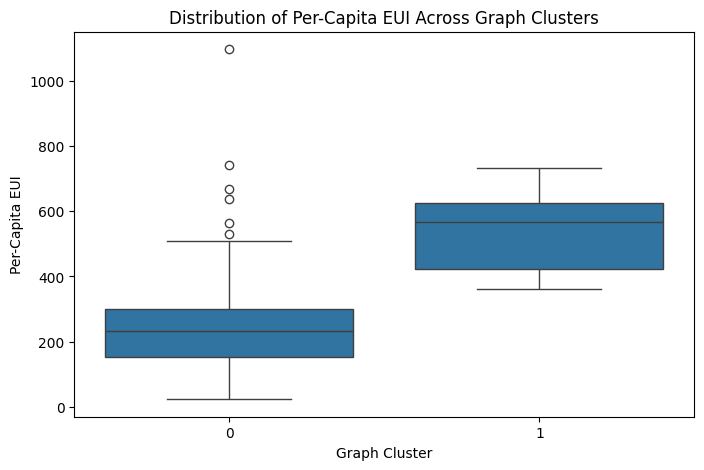

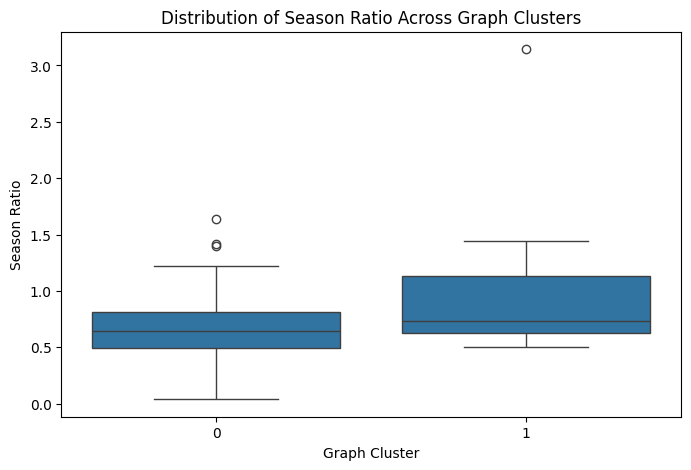

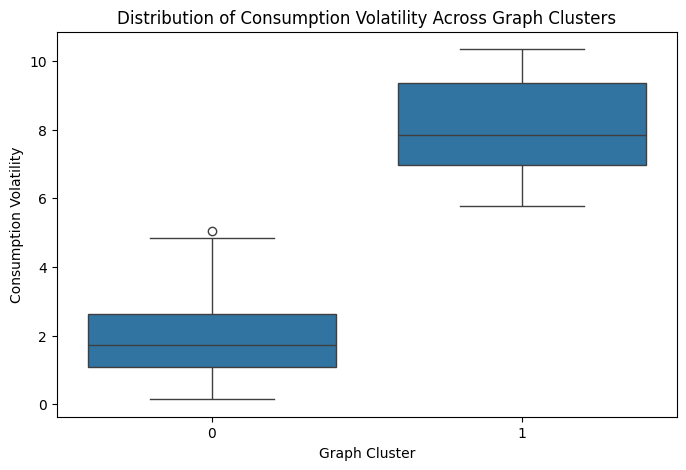


Percentage Distribution of Household Types Within Each Graph Cluster:


Household type,Basic,Water Heaters but no AC,With Air Conditioners
Graph_Cluster,,,
0,0.959459,0.92,0.904762
1,0.040541,0.08,0.095238


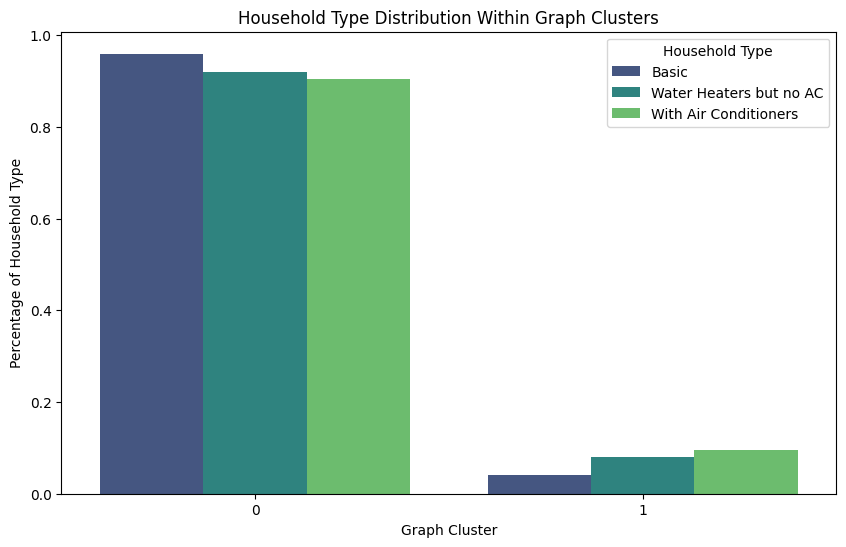

In [623]:
# Calculate the mean
cluster_means = behavioral_features.groupby('Graph_Cluster')[features_to_plot].mean()
print("Mean Behavioral Features per Cluster:")
display(cluster_means)

# Compare the distribution of the behavioral features
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=behavioral_features, x='Graph_Cluster', y=feature)
    plt.xlabel('Graph Cluster')
    plt.ylabel(feature)
    plt.title(f'Distribution of {feature} Across Graph Clusters')
    plt.show()

cluster_household_type_counts = behavioral_features.groupby('Graph_Cluster')['Household type'].value_counts().unstack(fill_value=0)
total_household_type_counts = behavioral_features['Household type'].value_counts()
cluster_household_type_percentage = cluster_household_type_counts.reindex(columns=total_household_type_counts.index, fill_value=0).apply(lambda col: col / total_household_type_counts[col.name] if total_household_type_counts[col.name] > 0 else 0, axis=0)

print("\nPercentage Distribution of Household Types Within Each Graph Cluster:")
display(cluster_household_type_percentage)

# Visualize the distribution of household types within each cluster
cluster_household_type_percentage_melted = cluster_household_type_percentage.reset_index().melt(id_vars='Graph_Cluster', var_name='Household type', value_name='Percentage')

plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_household_type_percentage_melted, x='Graph_Cluster', y='Percentage', hue='Household type', palette='viridis')
plt.xlabel('Graph Cluster')
plt.ylabel('Percentage of Household Type')
plt.title('Household Type Distribution Within Graph Clusters')
plt.xticks(range(optimal_n_clusters))
plt.legend(title='Household Type')
plt.show()
